In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress, skew
import datetime
import string
from matplotlib.gridspec import GridSpec


(c1,c2,c3,c4)=('#1b9e77','#d95f02','#7570b3','#e7298a')

solar_dict = pickle.load(open('../../pickles/solar_df','rb'))

/tmp/ipykernel_20078/1583786626.py:59: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(x['diff'])
/home/robbie/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robbie/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robbie/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2.0
60.0
BLI fully suppressed:
102.0
102.0
102.0


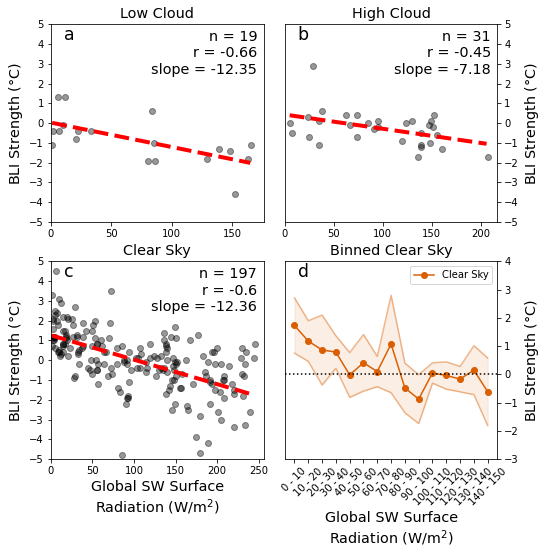

In [2]:
# DO NOT DELETE
# THIS ANALYSES THE SOLAR DICT

l=[]

for NP, d in solar_dict.items():

    for year,df in d.items():
      
        
#         df = df[~np.isnan(df['diffuse radiation'])]
        df = df[~np.isnan(df['global radiation'])]
        
        df = df[np.isin(df['month'],[1,2,3,4])]
#         df = df[np.isin(df['month'],[9,10,11,12])]
        
        df = df[~np.isnan(df['surface temp'])]
        
        df = df[df['surface temp'] <0]
        
        df['diff'] = df['tempC'] - df['surface temp']
            
        if df.shape[0]>0:
            l.append(df)
        
df = pd.concat(l,axis=0)
df.shape

df_lc = df[df['low cloud']>9]
df_no_low = df[df['low cloud']<1]
df_hc = df_no_low[df_no_low['total cloud']>9]
df_cs = df_no_low[df_no_low['total cloud']<1]

df_lc.shape[0],df_hc.shape[0],df_cs.shape[0]

binned = {'means':{},
          'stds':{},
          'wind':{}}

names = ['Low Cloud','High Cloud','Clear Sky']

for name in names:
    binned['means'][name] = []
    binned['stds'][name] = []
    binned['wind'][name] = []

bw=10

ranger = np.arange(bw/2,150,bw)

for i in ranger:
    
    for df,name in zip([df_lc,df_hc,df_cs],names):
    
        x = df[df['global radiation']<i+bw/2]
        x = x[x['global radiation']>i-bw/2]
        x = x[x['diff']>-4]
        
        mean = np.nanmean(x['diff'])
        std = np.nanstd(x['diff'])
        
        if x.shape[0]<2:
            mean = np.nan
            std = np.nan
            
        binned['means'][name].append(mean)
        binned['stds'][name].append(std)
        binned['wind'][name].append(np.nanmean(x['wind speed']))
        

fig, axs = plt.subplots(2,2,figsize=(8,8))

for df,name,ax in zip([df_lc,df_hc,df_cs],['Low Cloud','High Cloud','Clear Sky'],axs.reshape(-1)):

    ax.scatter(df['global radiation'],df['tempC']-df['surface temp'],color='k',alpha=0.4)
    
    lr = linregress(df['global radiation'],df['tempC']-df['surface temp'])
    
    if lr[3]<0.05:
        ax.annotate(f'n = {df.shape[0]}\nr = {np.round(lr[2],2)}\nslope = {np.round(lr[0]*1000,2)}',ha='right',va='top',
                    xy=(0.97,0.97),fontsize='x-large',xycoords='axes fraction',color='k')
    
        x=np.arange(np.min(df['global radiation']),np.max(df['global radiation']))
        ax.plot(x,x*lr[0]+lr[1],color='r',ls='--',lw=4)
        if name == 'Clear Sky':
            print('BLI fully suppressed:')
            print(x[np.argmin(np.abs(x*lr[0]+lr[1]))])
        
    else:
        ax.annotate(f'n = {df.shape[0]}',ha='right',va='top',
                    xy=(0.97,0.97),fontsize='x-large',xycoords='axes fraction',color='k')
    
        
    if name =='Clear Sky':
        print(x[np.argmin(np.abs(x*lr[0]+lr[1]))])
    
    ax.set_title(name,fontsize='x-large')
    
    ax.set_ylim(-5,5)
    ax.set_xlim(0,np.max(df['global radiation'])+10)
    
    print(x[np.argmin(np.abs(x*lr[0]+lr[1]))])
    
ax1,ax2,ax3,ax4 = axs.reshape(-1)

a = 0.4

ax4.plot(ranger,binned['means']['Clear Sky'],marker='o',label='Clear Sky',color=c2)
ax4.fill_between(ranger,
                 np.array(binned['means']['Clear Sky'])-np.array(binned['stds']['Clear Sky']),
                 np.array(binned['means']['Clear Sky'])+np.array(binned['stds']['Clear Sky']),
                 color=c2,
                 alpha=0.1)

ax4.plot(ranger,
         np.array(binned['means']['Clear Sky'])+np.array(binned['stds']['Clear Sky']),
         color=c2,alpha=a)
ax4.plot(ranger,
         np.array(binned['means']['Clear Sky'])-np.array(binned['stds']['Clear Sky']),
         color=c2,alpha=a)


ax4.set_title('Binned Clear Sky',fontsize='x-large')
    


ax4.legend()
ax4.set_xticks(ranger)
xticklabels = [f'{int(r-(bw/2))} - {int(r+(bw/2))}' for r in ranger]
ax4.set_xticklabels(xticklabels,rotation=45)

for ax in [ax2,ax4]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')


for ax,letter in zip(axs.reshape(-1),string.ascii_letters):
    
    ax.annotate(f'{letter}',
                xycoords='axes fraction',
                xy=(0.06,0.99),
                va='top',
                fontsize='xx-large')
    
    ax.set_ylabel('BLI Strength ($\degree$C)',fontsize='x-large')
    ax.set_yticks(np.arange(-5,6,1))
    
ax4.set_ylim(-3,4)

for ax in [ax3,ax4]:
    ax.set_xlabel('Global SW Surface\nRadiation (W/m$^2$)',fontsize='x-large')
    
ax4.axhline(0,color='k',ls=':')
    
plt.subplots_adjust(wspace=0.1)


plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/Inversion/main_figs/sw_radiometer_spring.png',dpi=400,bbox_inches='tight')

plt.show()

In [3]:
df_cs

,NP,year,month,day,tempC,RH%,pressure hPa,wind speed,total cloud,low cloud,...,longitude,diffuse radiation,direct radiation,global radiation,reflected radiation,albedo,net radiation,doy,zenith,diff
date,,,,,,,,,,,,,,,,,,,,,
1969-03-26,17,69,3,26,-43.9,80.0,1019.0,1,0.0,0.0,...,103.523,14.0,NaN,20.0,15.0,NaN,-17.0,85,87.730546,2.1
1969-03-27,17,69,3,27,-42.9,81.0,1024.9,1,0.0,0.0,...,100.933,16.0,NaN,25.0,17.0,NaN,-14.0,86,87.386866,2.1
1969-03-31,17,69,3,31,-40.0,82.0,1021.2,1,0.0,0.0,...,92.138,25.0,NaN,53.0,32.0,NaN,-4.0,90,85.981609,2.0
1969-04-01,17,69,4,1,-37.2,83.0,1021.5,3,0.0,0.0,...,91.142,26.0,NaN,51.0,33.0,NaN,-9.0,91,85.611618,1.8
1969-04-06,17,69,4,6,-34.7,84.0,1004.0,3,0.0,0.0,...,81.693,60.0,NaN,109.0,64.0,NaN,3.0,96,83.885489,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-04-17,31,90,4,17,-25.8,84.0,1015.9,2,0.0,0.0,...,225.700,78.0,NaN,179.0,143.0,NaN,NaN,107,70.281610,-2.8
1991-03-11,31,91,3,11,-34.2,77.0,1018.6,6,0.0,0.0,...,211.450,33.0,NaN,64.0,46.0,NaN,-21.0,70,78.378987,-0.2
1991-03-19,31,91,3,19,-30.9,79.0,1016.0,4,0.0,0.0,...,211.020,30.0,NaN,91.0,71.0,NaN,-22.0,78,75.262748,-1.9


In [4]:
d = []
an = []


df_ = df_lc.copy()

# df_.dropna(inplace=True)

lr = linregress(df_['global radiation'],df_['diff'])


for glob, diff, diffusivity in zip(df_['global radiation'],
                                   df_['diff'],
                                   df_['diffuse radiation']):
    
    if diff>0:
        if diff<100:

            d.append( diffusivity/glob )

            an.append( diff - (glob*lr[0]+lr[1]))

linregress(d,an)

LinregressResult(slope=-0.9511536765169298, intercept=2.3398578419459377, rvalue=-0.962101918896007, pvalue=0.1758267461043775, stderr=0.26958703471144246, intercept_stderr=0.25002890028838365)

In [5]:
l=[]

for NP, d in solar_dict.items():

    for year,df in d.items():
      
        
#         df = df[~np.isnan(df['diffuse radiation'])]
        df = df[~np.isnan(df['global radiation'])]
        
#         df = df[np.isin(df['month'],[1,2,3,4])]
        df = df[np.isin(df['month'],[9,10,11,12])]
        
        df = df[~np.isnan(df['surface temp'])]
        
        df = df[df['surface temp'] <0]
        
        df['diff'] = df['tempC'] - df['surface temp']
            
        if df.shape[0]>0:
            l.append(df)
        
df = pd.concat(l,axis=0)

df_lc = df[df['low cloud']>9]

binned = {'means':{},
          'stds':{},
          'wind':{}}

names = ['Low Cloud','High Cloud','Clear Sky']

for name in names:
    binned['means'][name] = []
    binned['stds'][name] = []
    binned['wind'][name] = []

bw=10

ranger = np.arange(bw/2,150,bw)

for i in ranger:
    
    for df,name in zip([df_lc,df_hc,df_cs],names):
    
        x = df[df['global radiation']<i+bw/2]
        x = x[x['global radiation']>i-bw/2]
        x = x[x['diff']>-4]
        
        mean = np.nanmean(x['diff'])
        std = np.nanstd(x['diff'])
        
        if x.shape[0]<2:
            mean = np.nan
            std = np.nan
            
        binned['means'][name].append(mean)
        binned['stds'][name].append(std)
        binned['wind'][name].append(np.nanmean(x['wind speed']))
        

/tmp/ipykernel_20078/266782461.py:50: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(x['diff'])
/home/robbie/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robbie/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robbie/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.0


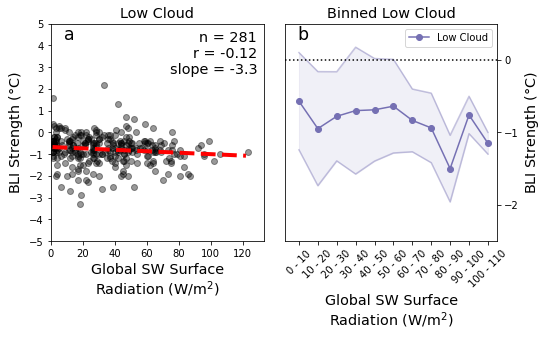

In [6]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

for df,name,ax in zip([df_lc],['Low Cloud'],[axs.reshape(-1)[0]]):

    ax.scatter(df['global radiation'],df['tempC']-df['surface temp'],color='k',alpha=0.4)
    
    lr = linregress(df['global radiation'],df['tempC']-df['surface temp'])
    
    if lr[3]<0.05:
        ax.annotate(f'n = {df.shape[0]}\nr = {np.round(lr[2],2)}\nslope = {np.round(lr[0]*1000,2)}',ha='right',va='top',
                    xy=(0.97,0.97),fontsize='x-large',xycoords='axes fraction',color='k')
    
        x=np.arange(np.min(df['global radiation']),np.max(df['global radiation']))
        ax.plot(x,x*lr[0]+lr[1],color='r',ls='--',lw=4)
        
    else:
        ax.annotate(f'n = {df.shape[0]}',ha='right',va='top',
                    xy=(0.97,0.97),fontsize='x-large',xycoords='axes fraction',color='k')
    
        
    if name =='Clear Sky':
        print(x[np.argmin(np.abs(x*lr[0]+lr[1]))])
    
    ax.set_title(name,fontsize='x-large')
    
    ax.set_ylim(-5,5)
    ax.set_xlim(0,np.max(df['global radiation'])+10)
    
    print(x[np.argmin(np.abs(x*lr[0]+lr[1]))])
    
ax1,ax4 = axs.reshape(-1)

a = 0.4

c = c3
ax4.plot(ranger,binned['means']['Low Cloud'],marker='o',label='Low Cloud',color=c)
ax4.fill_between(ranger,
                 np.array(binned['means']['Low Cloud'])-np.array(binned['stds']['Low Cloud']),
                 np.array(binned['means']['Low Cloud'])+np.array(binned['stds']['Low Cloud']),
                 color=c,
                 alpha=0.1)

ax4.plot(ranger,
         np.array(binned['means']['Low Cloud'])+np.array(binned['stds']['Low Cloud']),
         color=c,alpha=a)
ax4.plot(ranger,
         np.array(binned['means']['Low Cloud'])-np.array(binned['stds']['Low Cloud']),
         color=c,alpha=a)


ax4.set_title('Binned Low Cloud',fontsize='x-large')
    


ax4.legend()
ax4.set_xticks(ranger)
xticklabels = [f'{int(r-(bw/2))} - {int(r+(bw/2))}' for r in ranger]
ax4.set_xticklabels(xticklabels,rotation=45)

for ax in [ax2,ax4]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')


for ax,letter in zip(axs.reshape(-1),string.ascii_letters):
    
    ax.annotate(f'{letter}',
                xycoords='axes fraction',
                xy=(0.06,0.99),
                va='top',
                fontsize='xx-large')
    
    ax.set_ylabel('BLI Strength ($\degree$C)',fontsize='x-large')
    ax.set_yticks(np.arange(-5,6,1))
    
ax4.set_ylim(-2.5,0.5)
ax4.set_xlim(-2.5,110)

for ax in [ax1,ax4]:
    ax.set_xlabel('Global SW Surface\nRadiation (W/m$^2$)',fontsize='x-large')
    
ax4.axhline(0,color='k',ls=':')
    
plt.subplots_adjust(wspace=0.1)


plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/Inversion/supp_figs/sw_radiometer_fall.png',dpi=400,bbox_inches='tight')

plt.show()